# Training, Engineering, and Model Assesment - CNN DL Model

## Import packages 

In [48]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


# keras/tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import keras_tuner as kt

# stats
from scipy.stats import shapiro

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

We already have the df setup from the previous work. I have a bit of code here to enable switching back and forth between various datasets easily.

In [49]:
# set target (what are we trying to predict)
target = 'pwt_500hpa'
#target = 'temperature_800hpa'
# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py)
coords = [[180,240,45,65],[130,250,20,75]]
times = [['1940-01-01','2023-12-31']]  # Ensure the time range is valid

# set PC option - seperate or combined
#PC_option = 'combined'
PC_option = 'seperate'

# select which of the list I want to load
coords_num = 1
times_num = 0

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# read in PCs
if PC_option == 'combined':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_combined_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')
elif PC_option == 'seperate':
    raw_data = pd.read_csv(f'../data/dimensionality_reduction/principal_components_seperate_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}_target.csv')

# Keep only columns that are target, contain "PC", or contain "month"
#columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col or "month" in col]
columns_to_keep = [col for col in raw_data.columns if target in col or "PC" in col]
data = raw_data[columns_to_keep]

# normalize all input data to have values between 0 and 1, but keep as a df
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [50]:
# Prep data from ML

# Splitting the data into features X and label y
y = data[target].values  # e.g., binary classification label
X = data.drop(columns=[target]).values
# get names of features
feature_names = data.drop(columns=[target]).columns


# 70% training, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size=0.15, 
                                                  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.1765,  # 0.1765 of 0.85 ~ 0.15
                                                  random_state=42)

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## Hyperparameter Tuning

Here we explore a range of model archatectures to maximize preformance. I specify mse as the loss function as this is a common choice in regression. As the square of error, it punishes large errors more.
This model allows for tuning the following aspects in 50 randomized combinations.

- Number of filters in the first Conv1D layer (`conv1_filters`).
- Kernel size of the first Conv1D layer (`conv1_kernel_size`).
- Whether to include a second Conv1D layer (`use_second_conv`), and its filters and kernel size.
- Number of units in the Dense layer (`dense_units`).
- Whether to include a MaxPooling layer (`use_maxpool`).
- Whether to include a Dropout layer (`use_dropout`) and its dropout rate (`dropout_rate`).
- Learning rate for the Adam optimizer (`learning_rate`).

In [51]:
def build_model(hp):


    model = keras.Sequential()
    
    # # 1) First Conv1D layer

    
    # 2) Optional first Conv1D layer
    if hp.Boolean('use_first_conv'):
        model.add(layers.Conv1D(
            filters=hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
            input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]),
            activation='relu'
        ))

    # 2) Optional second Conv1D layer
    if hp.Boolean('use_second_conv'):
        model.add(layers.Conv1D(
            filters=hp.Int('conv2_filters', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
            activation='relu'
        ))
    
    # 3) Optional MaxPooling
    if hp.Boolean('use_maxpool'):
        model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Flatten())
    
    # 4) Dense layer(s)
    # Let’s tune the number of units in one hidden Dense layer.
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    
    # Optionally add dropout
    if hp.Boolean('use_dropout'):
        model.add(layers.Dropout(rate=hp.Float('dropout_rate',
                                               min_value=0.1,
                                               max_value=0.5,
                                               step=0.1)))
    
    # 5) Final output layer (for regression, a single unit with linear activation)
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    # Tune the learning rate for the optimizer as well
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mse']
    )
    
    return model


In [52]:
# Configure the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',          # what metric to optimize
    max_trials=50,                # how many configurations to try
    executions_per_trial=1,       # how many times to train each model
    directory='../data/my_tuner_dir',     # folder to store tuning logs
    project_name='cnn_regression'
)

# Incorporate Early Stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=3,
    restore_best_weights=True
)

## Run the hyperparameter search

Here I introduce the early_stop option, ensuring that models which are descreasing preformance over epochs stop training. I train to a maximum of 20 epochs, balancing runtime with preformance over the 50 combinations I'm considering.

In [53]:
t1 = time.perf_counter()
# Run the hyperparameter search
tuner.search(
    X_train_cnn, y_train,
    epochs=20,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stop]
)
t2 = time.perf_counter()
hyper_search_time = t2 - t1

Trial 50 Complete [00h 00m 02s]
val_mse: 0.5930352210998535

Best val_mse So Far: 0.5341405272483826
Total elapsed time: 00h 01m 13s


## K-Fold Cross Validation

Here we preform K-fold cross validation with 10 folds

In [56]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# combine train + val data
X_train_val = np.concatenate((X_train_cnn, X_val_cnn), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Perform k-fold cross-validation
num_folds = 10  # Number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store the history and MSE for each fold
val_scores = []  # Store validation scores for each fold
histories = []  # Store training history for each fold
best_epochs = []

# Store MSE and  for each fold
fold_mse = []

t1 = time.perf_counter()
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"Training fold {fold + 1}/{num_folds}...")

    # Split data for this fold
    X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]

    # Reinitialize model (since Keras models retain state)
    model = keras.models.clone_model(best_model)
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])

    # Train the model with early stopping
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20,  # Adjust based on your needs
        batch_size=32,  # Adjust as needed
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop],
        verbose=0
    )
    
    # Store history for plotting
    histories.append(history.history)
    
    # Store the best epoch (length of training before early stopping)
    best_epochs.append(len(history.history['mse']))

    # Evaluate on validation set
    val_loss, val_mse = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_scores.append(val_mse)
    print(f"Fold {fold + 1} Validation MSE: {val_mse:.4f}")

t2 = time.perf_counter()
cv_time = t2 - t1

# Average performance across folds
avg_val_mse = np.mean(val_scores)
avg_best_epoch = int(np.mean(best_epochs))  # Compute average best epoch from k-fold training
print(f"Average Validation MSE: {avg_val_mse:.4f}")
print(f"Using {avg_best_epoch} epochs for final training.")


Training fold 1/10...
Fold 1 Validation MSE: 0.7020
Training fold 2/10...
Fold 2 Validation MSE: 0.6827
Training fold 3/10...
Fold 3 Validation MSE: 0.6411
Training fold 4/10...
Fold 4 Validation MSE: 0.6519
Training fold 5/10...
Fold 5 Validation MSE: 0.5719
Training fold 6/10...
Fold 6 Validation MSE: 0.7338
Training fold 7/10...
Fold 7 Validation MSE: 0.8156
Training fold 8/10...
Fold 8 Validation MSE: 0.5463
Training fold 9/10...
Fold 9 Validation MSE: 0.8799
Training fold 10/10...
Fold 10 Validation MSE: 0.7309
Average Validation MSE: 0.6956
Using 6 epochs for final training.


In [57]:
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'use_first_conv': True, 'use_second_conv': True, 'use_maxpool': True, 'dense_units': 80, 'use_dropout': True, 'learning_rate': 0.001, 'conv1_filters': 112, 'conv1_kernel_size': 3, 'conv2_filters': 128, 'conv2_kernel_size': 5, 'dropout_rate': 0.1}


## Plot Training and Validation MSE Across Folds

Here we see that the model stops short on all of the cross validation folds as it fails to reduce validation mse, even while training error decreases. This points to overfitting, and a failure to produce real predictive power.

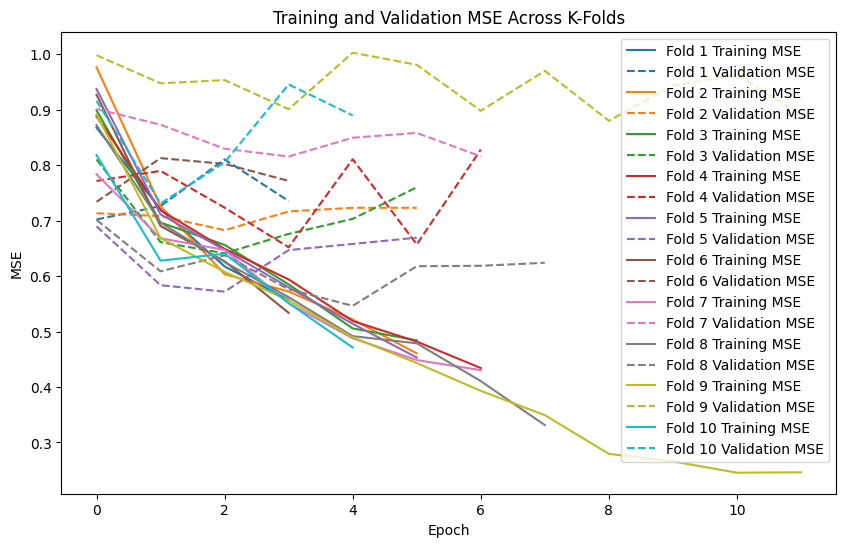

In [ ]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

for i, history in enumerate(histories):
    plt.plot(history['mse'], label=f'Fold {i+1} Training MSE', color=colors[i % len(colors)])
    plt.plot(history['val_mse'], linestyle='--', label=f'Fold {i+1} Validation MSE', color=colors[i % len(colors)])

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training and Validation MSE Across K-Folds")
plt.legend()
plt.show()


## Final model training, with evaluation on test set

Note that here we cannot use early stopping, so instead we train to the average number of folds from the cross validation

In [59]:
from sklearn.metrics import r2_score

# Final Training on Full Train+Val Data 
print("Training final model on full train+val dataset...")

final_model = keras.models.clone_model(best_model)
final_model.compile(optimizer="adam", loss="mse", metrics=["mse"])
t1 = time.perf_counter()
final_model.fit(
    X_train_val, y_train_val,
    epochs=avg_best_epoch,  # Use the averaged best epoch
    batch_size=32,
    verbose=0
)
t2 = time.perf_counter()
print(f"Training time: {t2 - t1:.2f} seconds")

#  Final Evaluation on Test Set 
test_loss, test_mse = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test MSE: {test_mse:.4f}")
# Calculate R^2 score
r2 = r2_score(y_test, final_model.predict(X_test))
print(f"Final Test R^2: {r2:.4f}")

Training final model on full train+val dataset...
Training time: 1.30 seconds
3/3 [==============================] - 0s 4ms/step - loss: 0.8200 - mse: 0.8200
Final Test MSE: 0.8200
3/3 [==============================] - 0s 2ms/step
Final Test R^2: 0.2221


In [66]:
# Save the results from this run to a csv

results = pd.DataFrame(columns=['model', '1 Run Time', 'mean_squared_error','mean_r2','Hyperparameter Time','K-Fold Time'])
results = pd.concat([results, pd.DataFrame([{'model': 'CNN', '1 Run Time': t2-t1, 'mean_squared_error': test_mse, 'mean_r2': r2, 'Hyperparameter Time': hyper_search_time, 'K-Fold Time': cv_time }])], ignore_index=True)
results.to_csv(f'../data/results/cnn_results.csv', index=False)

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_89331/198805526.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'model': 'CNN', '1 Run Time': t2-t1, 'mean_squared_error': test_mse, 'mean_r2': r2, 'Hyperparameter Time': hyper_search_time, 'K-Fold Time': cv_time }])], ignore_index=True)
